Before starting, you will need to install some packages to reproduce the baseline.

In [19]:
!pip install tqdm
!pip install scikit-learn

^C
ERROR: Operation cancelled by user


In [2]:
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

# Data architecture

After downloading or unzipping the downloaded files, your data tree must have the following architecture in order to properly run the notebook:
```
your_data_dir/
├── train_output.csv
├── train_input/
│   ├── images/
│       ├── ID_001/
│           ├── ID_001_tile_000_17_170_43.jpg
...
│   └── moco_features/
│       ├── ID_001.npy
...
├── test_input/
│   ├── images/
│       ├── ID_003/
│           ├── ID_003_tile_000_16_114_93.jpg
...
│   └── moco_features/
│       ├── ID_003.npy
...
├── supplementary_data/
│   ├── baseline.ipynb
│   ├── test_metadata.csv
│   └── train_metadata.csv
```

For instance, `your_data_dir = /storage/DATA_CHALLENGE_ENS_2022/`


This notebook aims to reproduce the baseline method on this challenge called `MeanPool`. This method consists in a logistic regression learnt on top of tile-level MoCo V2 features averaged over the slides.

For a given slide $s$ with $N_s=1000$ tiles and corresponding MoCo V2 features $\mathbf{K_s} \in \mathbb{R}^{(1000,\,2048)}$, a slide-level average is performed over the tile axis.

For $j=1,...,2048$:

$$\overline{\mathbf{k_s}}(j) = \frac{1}{N_s} \sum_{i=1}^{N_s} \mathbf{K_s}(i, j) $$

Thus, the training input data for MeanPool consists of $S_{\text{train}}=344$ mean feature vectors $\mathbf{k_s}$, $s=1,...,S_{\text{train}}$, where $S_{\text{train}}$ denotes the number of training samples.

## Data loading

In [3]:
# put your own path to the data root directory (see example in `Data architecture` section)
data_dir = Path("/Users/clementdesroches/Documents/MINES_3A/owkin_data_challenge")

# load the training and testing data sets
train_features_dir = data_dir / "train_input" / "moco_features"
test_features_dir = data_dir / "test_input" / "moco_features"
df_train = pd.read_csv(data_dir  / "supplementary_data" / "train_metadata.csv")
df_test = pd.read_csv(data_dir  / "supplementary_data" / "test_metadata.csv")

# concatenate y_train and df_train
y_train = pd.read_csv(data_dir  / "train_output.csv")
df_train = df_train.merge(y_train, on="Sample ID")

print(f"Training data dimensions: {df_train.shape}")  # (344, 4)
df_train.head()

Training data dimensions: (344, 4)


,Sample ID,Patient ID,Center ID,Target
0,ID_001.npy,P_001,C_1,0
1,ID_002.npy,P_002,C_2,1
2,ID_005.npy,P_005,C_5,0
3,ID_006.npy,P_006,C_5,0
4,ID_007.npy,P_007,C_2,1


## Data processing

We now load the features matrices $\mathbf{K_s} \in \mathbb{R}^{(1000,\,2048)}$ for $s=1,...,344$ and perform slide-level averaging. This operation should take at most 5 minutes on your laptop.

In [4]:
X_train = []
y_train = []
centers_train = []
patients_train = []

for sample, label, center, patient in tqdm(
    df_train[["Sample ID", "Target", "Center ID", "Patient ID"]].values
):
    # load the coordinates and features (1000, 3+2048)
    _features = np.load(train_features_dir / sample)
    # get coordinates (zoom level, tile x-coord on the slide, tile y-coord on the slide)
    # and the MoCo V2 features
    coordinates, features = _features[:, :3], _features[:, 3:]  # Ks
    # slide-level averaging
    X_train.append(features)
    y_train.append(label)
    centers_train.append(center)
    patients_train.append(patient)

# convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
centers_train = np.array(centers_train)
patients_train = np.array(patients_train)

100%|██████████| 344/344 [00:05<00:00, 62.90it/s]


In [5]:
print(f"X_train shape: {X_train.shape}")  # (344, 1000, 2048)

# X_train = X_train.reshape(X_train.shape[0], X_train.shape[2],  X_train.shape[1])
# print(f"X_train shape: {X_train.shape}")  # (344, 2048, 1000)


X_train shape: (344, 1000, 2048)


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class LogisticRegression(torch.nn.Module):
    def __init__(self, n=2048, n_out=1):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(n, n_out)
        self.scoring = torch.nn.Softmax() if n_out>1 else torch.nn.Sigmoid()

    def forward(self, x):
        z = self.linear(x)
        y_pred = self.scoring(z)
        return y_pred

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.cnn_layers = nn.Sequential(
            nn.Conv1d(1000, 10, 6, stride=1, padding=1),
            nn.ReLU(),
        nn.MaxPool1d(1,1),
            nn.Conv1d(10, 1, 6, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(1,1),
        )


    def forward(self, x):
        x = self.cnn_layers(x)
        x = torch.nn.Dropout(0.3)(x)
        ## resize to (344, 2048)
        x = x.view(x.size(0), -1)
        n = x.size(1)
        x = LogisticRegression(n = n, n_out = 1)(x)
        return x
    
net = Net()
net.train()

Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn_layers): Sequential(
    (0): Conv1d(1000, 10, kernel_size=(6,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(10, 1, kernel_size=(6,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
)

In [28]:
## train val split
from sklearn.model_selection import train_test_split
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train_2 = torch.from_numpy(X_train1).float()
y_train_2 = torch.from_numpy(y_train1).float()

X_val_2 = torch.from_numpy(X_val1).float()
y_val_2 = torch.from_numpy(y_val1).float()



def train_model(epoch):
    # clearing the Gradients of the model parameters
    optimizer.zero_grad()

    # prediction for training and validation set
    output_train = net(X_train_2)
    output_val = net(X_val_2)

    # reshaping the predictions in the form of (batch_size,)
    output_train = output_train.reshape(-1)
    output_val = output_val.reshape(-1)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train_2)
    train_losses.append(loss_train)
    train_acc.append(roc_auc_score(y_train_2, output_train.detach().numpy()))
    loss_val = criterion(output_val, y_val_2)
    val_losses.append(loss_val)
    val_acc.append(roc_auc_score(y_val_2, output_val.detach().numpy()))

    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%1 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_train, '\t', 'acc :', train_acc[-1], '\t', 'val_loss :', loss_val, '\t', 'val_acc :', val_acc[-1])

In [48]:
X_train_2.shape

torch.Size([275, 1000, 2048])

In [49]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters())
# defining the number of epochs
n_epochs = 20
# empty list to store training losses
train_losses = []
# accuracy on training set
train_acc = []
# empty list to store validation losses
val_losses = []

val_acc = []

if torch.cuda.is_available():
    net = net.cuda()
    criterion = criterion.cuda()
# training the model
for epoch in range(n_epochs):
    train_model(epoch)

Epoch :  1 	 loss : tensor(0.6954, grad_fn=<BinaryCrossEntropyBackward0>) 	 acc : 0.5384679572763685 	 val_loss : tensor(0.6895, grad_fn=<BinaryCrossEntropyBackward0>) 	 val_acc : 0.5238095238095238
Epoch :  2 	 loss : tensor(0.6925, grad_fn=<BinaryCrossEntropyBackward0>) 	 acc : 0.5420004450378282 	 val_loss : tensor(0.6891, grad_fn=<BinaryCrossEntropyBackward0>) 	 val_acc : 0.5694444444444443
Epoch :  3 	 loss : tensor(0.6937, grad_fn=<BinaryCrossEntropyBackward0>) 	 acc : 0.46256119270137963 	 val_loss : tensor(0.6910, grad_fn=<BinaryCrossEntropyBackward0>) 	 val_acc : 0.4285714285714286
Epoch :  4 	 loss : tensor(0.6961, grad_fn=<BinaryCrossEntropyBackward0>) 	 acc : 0.5149643969737427 	 val_loss : tensor(0.6907, grad_fn=<BinaryCrossEntropyBackward0>) 	 val_acc : 0.5277777777777778
Epoch :  5 	 loss : tensor(0.6954, grad_fn=<BinaryCrossEntropyBackward0>) 	 acc : 0.47463284379172227 	 val_loss : tensor(0.6946, grad_fn=<BinaryCrossEntropyBackward0>) 	 val_acc : 0.5099206349206349
Epo

KeyboardInterrupt: 

## 5-fold cross validation

In [39]:
# /!\ we perform splits at the patient level so that all samples from the same patient
# are found in the same split

patients_unique = np.unique(patients_train)
y_unique = np.array(
    [np.mean(y_train[patients_train == p]) for p in patients_unique]
)
centers_unique = np.array(
    [centers_train[patients_train == p][0] for p in patients_unique]
)

print(
    "Training set specifications\n"
    "---------------------------\n"
    f"{len(X_train)} unique samples\n"
    f"{len(patients_unique)} unique patients\n"
    f"{len(np.unique(centers_unique))} unique centers"
)

Training set specifications
---------------------------
344 unique samples
305 unique patients
3 unique centers


In [40]:
from xgboost import XGBClassifier

aucs = []
lrs = []
# 5-fold CV is repeated 5 times with different random states
for k in range(5):
    kfold = StratifiedKFold(5, shuffle=True, random_state=k)
    fold = 0
    # split is performed at the patient-level
    for train_idx_, val_idx_ in kfold.split(patients_unique, y_unique):
        # retrieve the indexes of the samples corresponding to the
        # patients in `train_idx_` and `test_idx_`
        train_idx = np.arange(len(X_train))[
            pd.Series(patients_train).isin(patients_unique[train_idx_])
        ]
        val_idx = np.arange(len(X_train))[
            pd.Series(patients_train).isin(patients_unique[val_idx_])
        ]
        # set the training and validation folds
        X_fold_train = X_train[train_idx]
        y_fold_train = y_train[train_idx]
        X_fold_val = X_train[val_idx]
        y_fold_val = y_train[val_idx]
        # instantiate the model
        lr = LogisticRegression(C=0.01, solver="liblinear")
        # fit it
        lr.fit(X_fold_train, y_fold_train)
        # get the predictions (1-d probability)
        preds_val = lr.predict_proba(X_fold_val)[:, 1]
        # compute the AUC score using scikit-learn
        auc = roc_auc_score(y_fold_val, preds_val)
        print(f"AUC on split {k} fold {fold}: {auc:.3f}")
        aucs.append(auc)
        # add the logistic regression to the list of classifiers
        lrs.append(lr)
        fold += 1
    print("----------------------------")
print(
    f"5-fold cross-validated AUC averaged over {k+1} repeats: "
    f"{np.mean(aucs):.3f} ({np.std(aucs):.3f})"
)

AUC on split 0 fold 0: 0.572
AUC on split 0 fold 1: 0.511
AUC on split 0 fold 2: 0.512
AUC on split 0 fold 3: 0.633
AUC on split 0 fold 4: 0.370
----------------------------
AUC on split 1 fold 0: 0.445
AUC on split 1 fold 1: 0.660
AUC on split 1 fold 2: 0.431
AUC on split 1 fold 3: 0.488
AUC on split 1 fold 4: 0.522
----------------------------
AUC on split 2 fold 0: 0.515
AUC on split 2 fold 1: 0.460
AUC on split 2 fold 2: 0.533
AUC on split 2 fold 3: 0.623
AUC on split 2 fold 4: 0.470
----------------------------
AUC on split 3 fold 0: 0.587
AUC on split 3 fold 1: 0.438
AUC on split 3 fold 2: 0.519
AUC on split 3 fold 3: 0.481
AUC on split 3 fold 4: 0.474
----------------------------
AUC on split 4 fold 0: 0.505
AUC on split 4 fold 1: 0.475
AUC on split 4 fold 2: 0.509
AUC on split 4 fold 3: 0.436
AUC on split 4 fold 4: 0.593
----------------------------
5-fold cross-validated AUC averaged over 5 repeats: 0.511 (0.068)


# Submission

Now we evaluate the previous models trained through cross-validation so that to produce a submission file that can directly be uploaded on the data challenge platform.

## Data processing

In [25]:
X_test = []

# load the data from `df_test` (~ 1 minute)
for sample in tqdm(df_test["Sample ID"].values):
    _features = np.load(test_features_dir / sample)
    coordinates, features = _features[:, :3], _features[:, 3:]
    X_test.append(np.mean(features, axis=0))

X_test = np.array(X_test)

100%|██████████| 149/149 [00:01<00:00, 120.94it/s]


## Inference

In [26]:
preds_test = 0
# loop over the classifiers
for lr in lrs:
    preds_test += rf.predict_proba(X_test)[:, 1]
# and take the average (ensembling technique)
preds_test = preds_test / len(lrs)

NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

## Saving predictions

In [ ]:
submission = pd.DataFrame(
    {"Sample ID": df_test["Sample ID"].values, "Target": preds_test}
).sort_values(
    "Sample ID"
)  # extra step to sort the sample IDs

# sanity checks
assert all(submission["Target"].between(0, 1)), "`Target` values must be in [0, 1]"
assert submission.shape == (149, 2), "Your submission file must be of shape (149, 2)"
assert list(submission.columns) == [
    "Sample ID",
    "Target",
], "Your submission file must have columns `Sample ID` and `Target`"

# save the submission as a csv file
submission.to_csv(data_dir / "benchmark_test_output.csv", index=None)
submission.head()

,Sample ID,Target
0,ID_003.npy,0.423755
1,ID_004.npy,0.418803
2,ID_008.npy,0.414833
3,ID_009.npy,0.417029
4,ID_010.npy,0.384043


# Dealing with images

The following code aims to load and manipulate the images provided as part of  this challenge.

## Scanning images paths on disk

This operation can take up to 5 minutes.

In [ ]:
train_images_dir = data_dir / "train_input" / "images"
train_images_files = list(train_images_dir.rglob("*.jpg"))

test_images_dir = data_dir / "test_input" / "images"
test_images_files = list(test_images_dir.rglob("*.jpg"))

print(
    f"Number of images\n"
    "-----------------\n"
    f"Train: {len(train_images_files)}\n" # 344 x 1000 = 344,000 tiles
    f"Test: {len(test_images_files)}\n"  # 149 x 1000 = 149,000 tiles
    f"Total: {len(train_images_files) + len(test_images_files)}\n"  # 493 x 1000 = 493,000 tiles
)

Number of images
-----------------
Train: 0
Test: 0
Total: 0



## Reading

Now we can load some of the `.jpg` images for a given sample, say `ID_001`.

In [ ]:
ID_001_tiles = [p for p in train_images_files if 'ID_001' in p.name]

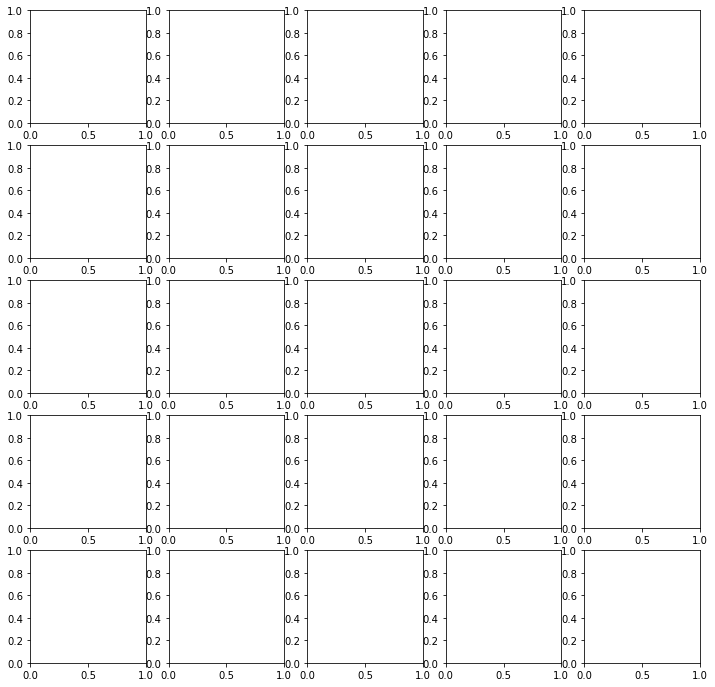

In [ ]:
fig, axes = plt.subplots(5, 5)
fig.set_size_inches(12, 12)

for i, img_file in enumerate(ID_001_tiles[:25]):
    # get the metadata from the file path
    _, metadata = str(img_file).split("tile_")
    id_tile, level, x, y = metadata[:-4].split("_")
    img = plt.imread(img_file)
    ax = axes[i//5, i%5]
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Tile {id_tile} ({x}, {y})")
plt.show()

## Mapping with features

Note that the coordinates in the features matrices and tiles number are aligned.

In [ ]:
sample = "ID_001.npy"
_features = np.load(train_features_dir / sample)
coordinates, features = _features[:, :3], _features[:, 3:]
print("xy features coordinates")
coordinates[:10, 1:].astype(int)

xy features coordinates


array([[170,  43],
       [245,  49],
       [137, 128],
       [218,  40],
       [142, 117],
       [129,  72],
       [129,  88],
       [164, 109],
       [210,  39],
       [222, 100]])

In [ ]:
print(
    "Tiles numbering and features coordinates\n"
)
[tile.name for tile in ID_001_tiles[:10]]

Tiles numbering and features coordinates



[]